In [2]:
%%capture
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.interpolate
from matplotlib import rcParams
from scipy.stats import kendalltau

In [3]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

# rcParams['axes.edgecolor'] = 'grey'
# rcParams['legend.edgecolor'] = 'grey'

hue_order = ["LMI", "KSG", "MINE", "InfoNCE"]
c6 = ['#c4bae2','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]
palette = [c6[c] for c in range(6) if c in [1,2,3,5]]

In [4]:
def samples_needed(group, eps=0.1):
    s = group['Sample number'].values
    e = group['Error'].values
    sample_interp = scipy.interpolate.interp1d(e, s, 
                                               bounds_error=False,
                                               fill_value=(np.nan, min(s)))
#     for i in range(len(s)):
#         if e[i] < eps:
#             return s[i]
    return sample_interp(eps)

def sample_complexity_curves(res_df, eps=0.1):
    
    res_df['Error'] = np.abs((res_df['Estimate'] * 
                              (res_df['Estimate'] > 0)) - res_df['True MI'])

    mean_error = res_df.groupby(['Estimator', 
                    'Ambient dimensions', 
                    'Sample number'])['Error'].mean().reset_index()

    complexity_curves = mean_error.groupby(['Estimator', 
                                        'Ambient dimensions']).apply(samples_needed,
                                                                    eps=eps).unstack()

    complexity_curves = complexity_curves.reset_index().melt(ignore_index=True, 
                                         id_vars=['Estimator'], value_name='Samples needed')
    complexity_curves['Samples needed'] = complexity_curves['Samples needed'].astype('float')
    
    return complexity_curves

In [5]:
def letter_annotation(ax, xoffset, yoffset, letter):
     ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
             size=12, weight='bold')

Text(0.5, 1.0, '$k= d$')

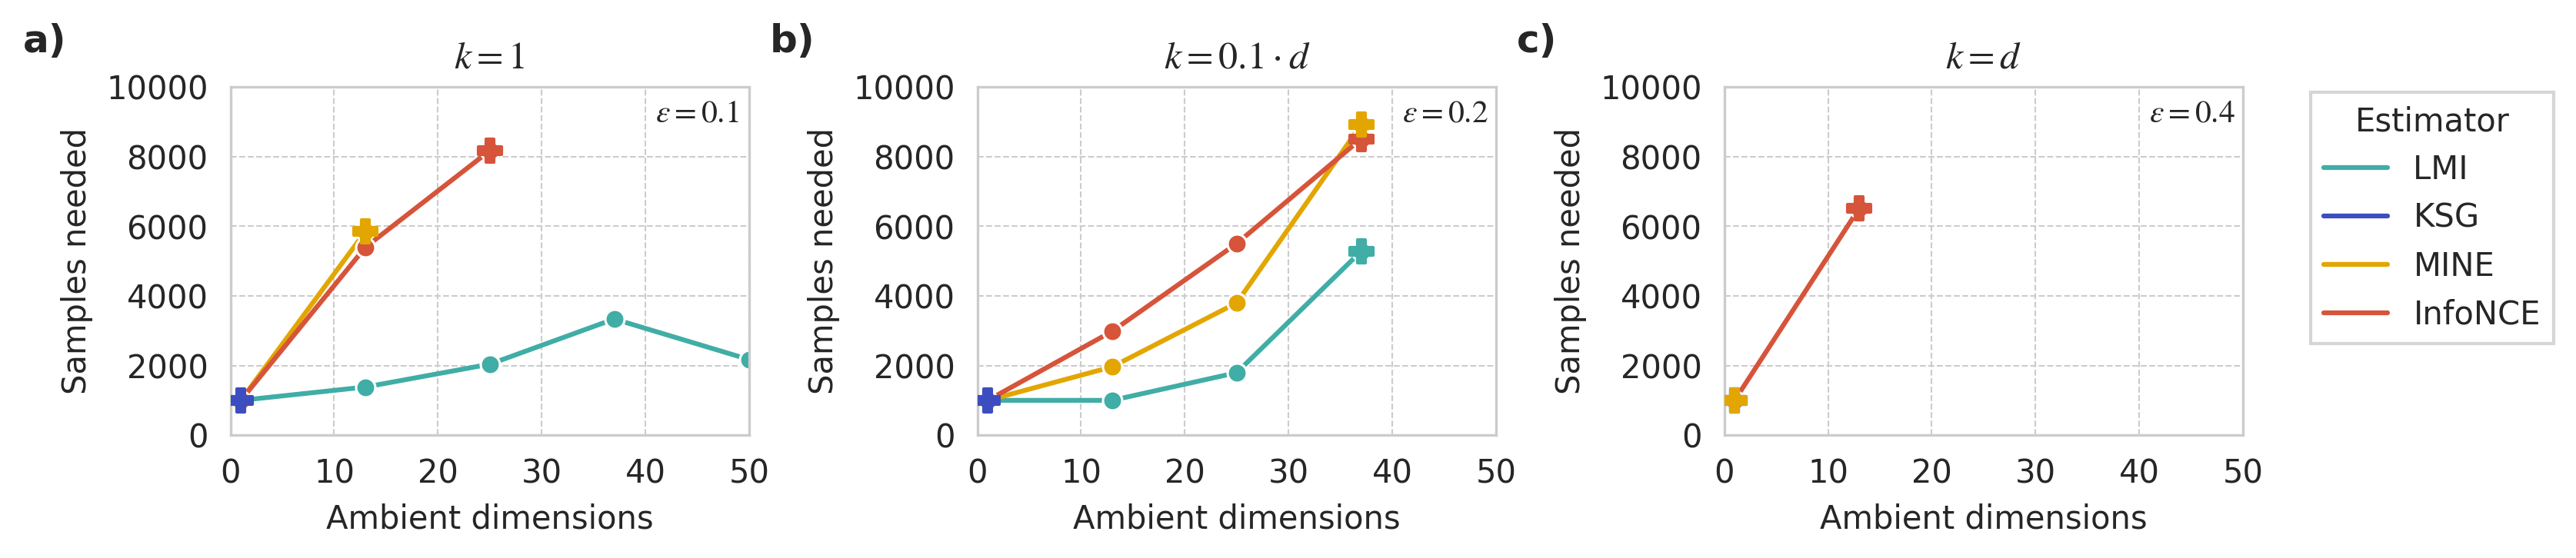

In [6]:
fig = plt.figure(figsize=(10, 2), dpi=300)

low, med, hi, leg = fig.subfigures(1, 4, wspace=0.15,
                                  width_ratios= (1, 1, 1, 0.1))

ax_l = low.subplots()
ax_m = med.subplots()
ax_h = hi.subplots()

##################
#### LOW RANK ####
##################
hue_order = ["LMI", "KSG", "MINE", "InfoNCE"]


res_df = pd.read_csv('B_Gaussian_sample_complexity_low_rank.csv', index_col=0)
complexity_curves = sample_complexity_curves(res_df, eps=0.1)
sns.lineplot(complexity_curves.dropna(), marker='o',
            x='Ambient dimensions', y='Samples needed',
            hue='Estimator', hue_order=hue_order,
                palette=palette, ax=ax_l, legend=False)

for row in complexity_curves.dropna().drop_duplicates('Estimator', keep='last').iterrows():
    if row[1]['Ambient dimensions'] < 50:
#         ax_l.text(row[1]['Ambient dimensions'], row[1]['Samples needed'], '✖',
#               horizontalalignment='center',
#               verticalalignment='center', color='black')
        ax_l.scatter(row[1]['Ambient dimensions'], row[1]['Samples needed'],
                marker='P', s=50, zorder=3, 
                 color=palette[hue_order.index(row[1]['Estimator'])])
ax_l.set_ylim(0, 10**4)
ax_l.set_xlim(0, 50)
ax_l.set_title(r'$k=1$')


##################
#### MED RANK ####
##################


res_df = pd.read_csv('B_Gaussian_sample_complexity_medium_rank.csv', index_col=0)
complexity_curves = sample_complexity_curves(res_df, eps=0.2)
sns.lineplot(complexity_curves.dropna(), marker='o',
            x='Ambient dimensions', y='Samples needed',
            hue='Estimator', hue_order=hue_order, legend=False,
                palette=palette, ax=ax_m)

for row in complexity_curves.dropna().drop_duplicates('Estimator', keep='last').iterrows():
    if row[1]['Ambient dimensions'] < 50:
#         ax_m.text(row[1]['Ambient dimensions'], row[1]['Samples needed'], '✖',
#               horizontalalignment='center',
#               verticalalignment='center', color='black')
        ax_m.scatter(row[1]['Ambient dimensions'], row[1]['Samples needed'],
                marker='P', s=50, zorder=3, 
                 color=palette[hue_order.index(row[1]['Estimator'])])
ax_m.set_ylim(0, 10**4)
ax_m.set_xlim(0, 50)
ax_m.set_title(r'$k=0.1 \cdot d$')


##################
#### MED RANK ####
##################

hue_order = ["LMI ", "KSG", "MINE", "InfoNCE"]
res_df = pd.read_csv('B_Gaussian_sample_complexity_high_rank.csv', index_col=0)
complexity_curves = sample_complexity_curves(res_df, eps=0.4)
sns.lineplot(complexity_curves.dropna(), marker='o',
            x='Ambient dimensions', y='Samples needed',
            hue='Estimator', hue_order=hue_order,
                palette=palette, ax=ax_h)
sns.move_legend(ax_h, "upper left", bbox_to_anchor=(1.1, 1.03))

for row in complexity_curves.dropna().drop_duplicates('Estimator', keep='last').iterrows():
    if row[1]['Ambient dimensions'] < 50:
#         ax_h.text(row[1]['Ambient dimensions'], row[1]['Samples needed'], '❎',
#               horizontalalignment='center',
#               verticalalignment='center', color='black')

        ax_h.scatter(row[1]['Ambient dimensions'], row[1]['Samples needed'],
                marker='P', s=50, zorder=3, 
                 color=palette[hue_order.index(row[1]['Estimator'])])

ax_h.text(41, 9000, "$\\epsilon = 0.4$")
ax_m.text(41, 9000, "$\\epsilon = 0.2$")
ax_l.text(41, 9000, "$\\epsilon = 0.1$")

letter_annotation(ax_h, -.4, 1.1, "c)")
letter_annotation(ax_m, -.4, 1.1, "b)")
letter_annotation(ax_l, -.4, 1.1, "a)")

ax_h.set_ylim(0, 10**4)
ax_h.set_xlim(0, 50)
ax_h.set_title(r'$k= d$')

Text(0.5, 1.0, '$k= d$')

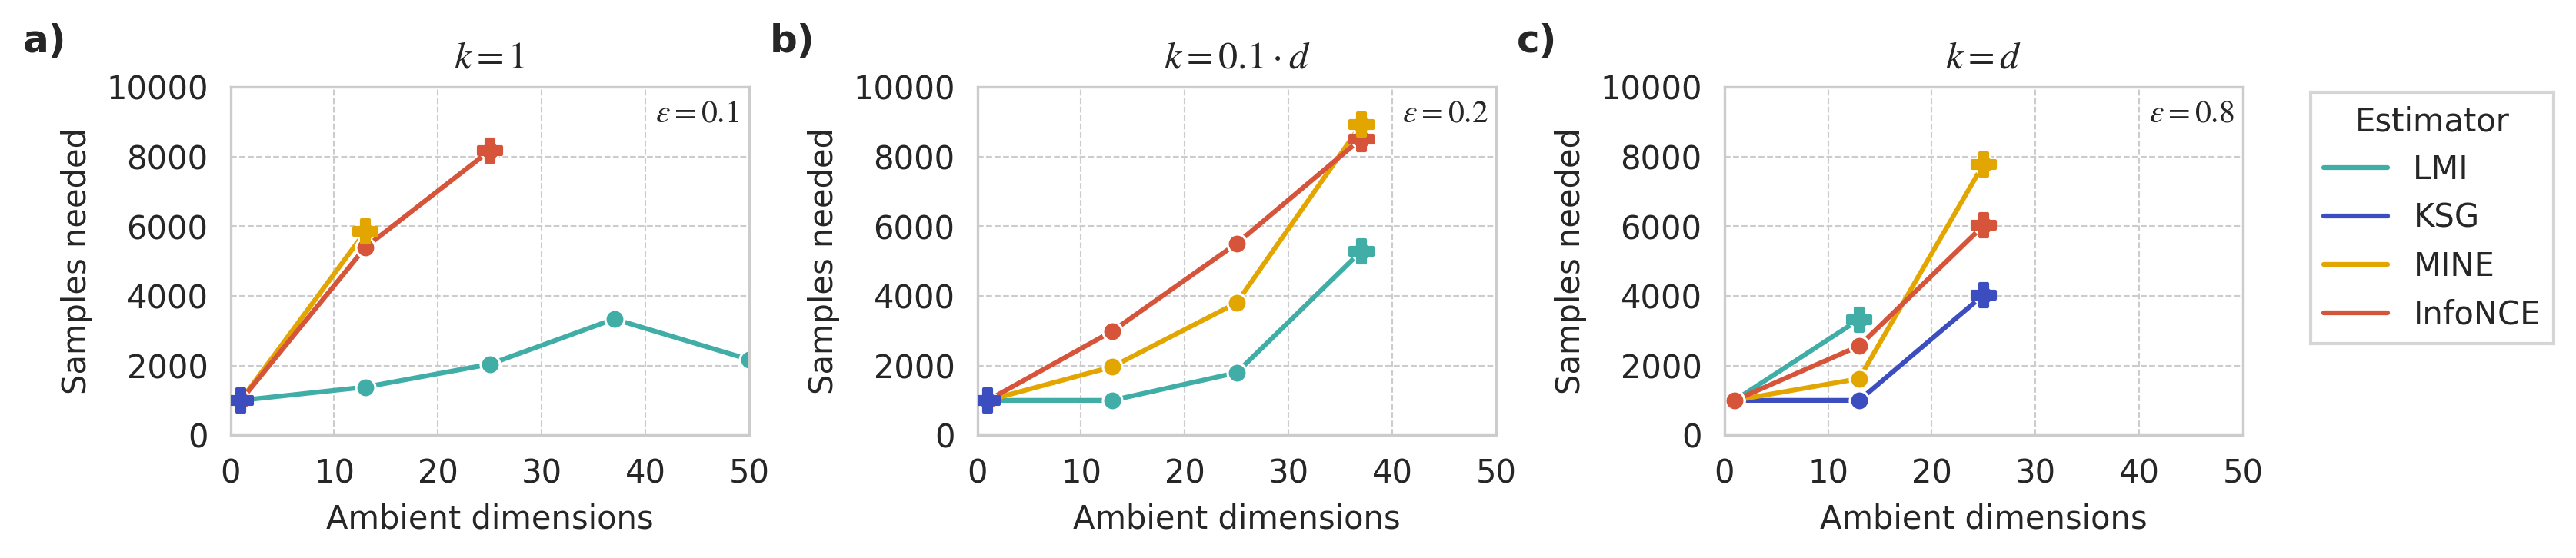

In [12]:
fig = plt.figure(figsize=(10, 2), dpi=300)

low, med, hi, leg = fig.subfigures(1, 4, wspace=0.15,
                                  width_ratios= (1, 1, 1, 0.1))

ax_l = low.subplots()
ax_m = med.subplots()
ax_h = hi.subplots()

##################
#### LOW RANK ####
##################
hue_order = ["LMI", "KSG", "MINE", "InfoNCE"]


res_df = pd.read_csv('B_Gaussian_sample_complexity_low_rank.csv', index_col=0)
complexity_curves = sample_complexity_curves(res_df, eps=0.1)
sns.lineplot(complexity_curves.dropna(), marker='o',
            x='Ambient dimensions', y='Samples needed',
            hue='Estimator', hue_order=hue_order,
                palette=palette, ax=ax_l, legend=False)

for row in complexity_curves.dropna().drop_duplicates('Estimator', keep='last').iterrows():
    if row[1]['Ambient dimensions'] < 50:
#         ax_l.text(row[1]['Ambient dimensions'], row[1]['Samples needed'], '✖',
#               horizontalalignment='center',
#               verticalalignment='center', color='black')
        ax_l.scatter(row[1]['Ambient dimensions'], row[1]['Samples needed'],
                marker='P', s=50, zorder=3, 
                 color=palette[hue_order.index(row[1]['Estimator'])])
ax_l.set_ylim(0, 10**4)
ax_l.set_xlim(0, 50)
ax_l.set_title(r'$k=1$')


##################
#### MED RANK ####
##################


res_df = pd.read_csv('B_Gaussian_sample_complexity_medium_rank.csv', index_col=0)
complexity_curves = sample_complexity_curves(res_df, eps=0.2)
sns.lineplot(complexity_curves.dropna(), marker='o',
            x='Ambient dimensions', y='Samples needed',
            hue='Estimator', hue_order=hue_order, legend=False,
                palette=palette, ax=ax_m)

for row in complexity_curves.dropna().drop_duplicates('Estimator', keep='last').iterrows():
    if row[1]['Ambient dimensions'] < 50:
#         ax_m.text(row[1]['Ambient dimensions'], row[1]['Samples needed'], '✖',
#               horizontalalignment='center',
#               verticalalignment='center', color='black')
        ax_m.scatter(row[1]['Ambient dimensions'], row[1]['Samples needed'],
                marker='P', s=50, zorder=3, 
                 color=palette[hue_order.index(row[1]['Estimator'])])
ax_m.set_ylim(0, 10**4)
ax_m.set_xlim(0, 50)
ax_m.set_title(r'$k=0.1 \cdot d$')


##################
#### MED RANK ####
##################

hue_order = ["LMI ", "KSG", "MINE", "InfoNCE"]
res_df = pd.read_csv('B_Gaussian_sample_complexity_high_rank.csv', index_col=0)
complexity_curves = sample_complexity_curves(res_df, eps=0.8)
sns.lineplot(complexity_curves.dropna(), marker='o',
            x='Ambient dimensions', y='Samples needed',
            hue='Estimator', hue_order=hue_order,
                palette=palette, ax=ax_h)
sns.move_legend(ax_h, "upper left", bbox_to_anchor=(1.1, 1.03))

for row in complexity_curves.dropna().drop_duplicates('Estimator', keep='last').iterrows():
    if row[1]['Ambient dimensions'] < 50:
#         ax_h.text(row[1]['Ambient dimensions'], row[1]['Samples needed'], '❎',
#               horizontalalignment='center',
#               verticalalignment='center', color='black')

        ax_h.scatter(row[1]['Ambient dimensions'], row[1]['Samples needed'],
                marker='P', s=50, zorder=3, 
                 color=palette[hue_order.index(row[1]['Estimator'])])

ax_h.text(41, 9000, "$\\epsilon = 0.8$")
ax_m.text(41, 9000, "$\\epsilon = 0.2$")
ax_l.text(41, 9000, "$\\epsilon = 0.1$")

letter_annotation(ax_h, -.4, 1.1, "c)")
letter_annotation(ax_m, -.4, 1.1, "b)")
letter_annotation(ax_l, -.4, 1.1, "a)")

ax_h.set_ylim(0, 10**4)
ax_h.set_xlim(0, 50)
ax_h.set_title(r'$k= d$')